In [1]:
import os
import re
import string
import numpy as np
import requests
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from io import BytesIO
import requests
import nltk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.regularizers import l2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier, VotingClassifier
)
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import InstanceHardnessThreshold
import missingno as ms
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense, GRU, BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### 🌐 Data Collection From URL and Convert to CSV File

This process involves fetching data from a specified URL and saving it into a structured CSV format for further analysis.


In [2]:
url = "http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz"
output_csv = "data_set.csv"
print("Downloading dataset...")
response = requests.get(url)
if response.status_code != 200:
    raise Exception("Failed to download the dataset")
print("Extracting dataset...")
tar = tarfile.open(fileobj=BytesIO(response.content), mode="r:gz")
tar.extractall(path="movie_reviews")
tar.close()
reviews = []
labels = []
base_dir = "movie_reviews/txt_sentoken"
pos_dir = os.path.join(base_dir, "pos")
for filename in os.listdir(pos_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(pos_dir, filename), "r", encoding="utf-8") as file:
            review = file.read().strip()
            reviews.append(review)
            labels.append(1)
neg_dir = os.path.join(base_dir, "neg")
for filename in os.listdir(neg_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(neg_dir, filename), "r", encoding="utf-8") as file:
            review = file.read().strip()
            reviews.append(review)
            labels.append(0)
print("Creating CSV file...")
data = {"review": reviews, "sentiment": labels}
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False, encoding="utf-8")
print(f"Dataset saved to {output_csv}")
import shutil
shutil.rmtree("movie_reviews")
print("Cleaned up temporary files")

Extracting dataset...
Creating CSV file...
Dataset saved to data_set.csv
Cleaned up temporary files


In [3]:
pd.options.mode.chained_assignment = None

In [4]:
dataf = pd.read_csv("/content/data_set.csv")
dataf.head()

,review,sentiment
0,john carpenter directed this stylish and gory ...,1
1,so many students strive to get into schools su...,1
2,ralph fiennes is carving out a nice niche for ...,1
3,not since oliver stone's natural born killers ...,1
4,"it is simply amazing how "" the green mile "" de...",1


# Encoding and Display Correlation Matrix

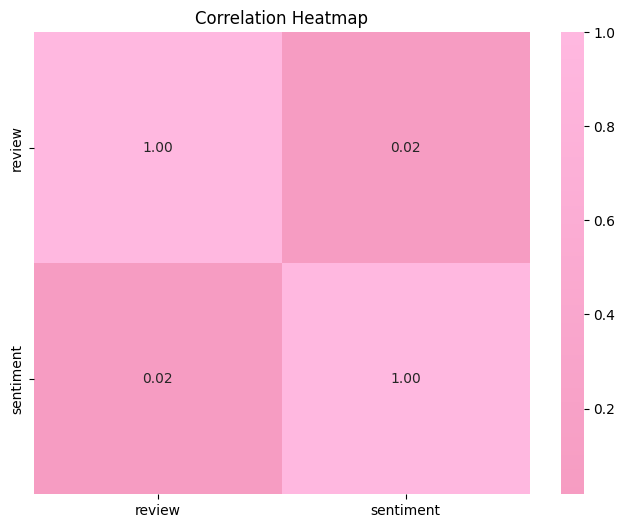

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
original_encodings = {}
categorical_columns = ['review']
label_encoder = LabelEncoder()
for column in categorical_columns:
    dataf[column] = label_encoder.fit_transform(dataf[column])
    original_encodings[column] = label_encoder

correlation_matrix = dataf.corr()
colors = ['#EC7FA2', '#FFB8E0']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".2f", center=0)
plt.title('Correlation Heatmap')
plt.show()

# Undo The Encoding

In [6]:
for column in categorical_columns:
    label_encoder = original_encodings[column]
    dataf[column] = label_encoder.inverse_transform(dataf[column])
print(dataf.head())

                                              review  sentiment
0  john carpenter directed this stylish and gory ...          1
1  so many students strive to get into schools su...          1
2  ralph fiennes is carving out a nice niche for ...          1
3  not since oliver stone's natural born killers ...          1
4  it is simply amazing how " the green mile " de...          1


# 🔤 Convert All Reviews into lower Case

In [7]:
dataf = dataf.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
dataf.head()

,review,sentiment
0,john carpenter directed this stylish and gory ...,1
1,so many students strive to get into schools su...,1
2,ralph fiennes is carving out a nice niche for ...,1
3,not since oliver stone's natural born killers ...,1
4,"it is simply amazing how "" the green mile "" de...",1


### 🧹 Clean Text: Remove Duplicates, Stop Words & Punctuation
Simplifies text by removing repeated words, stop words, and punctuation for cleaner analysis.

In [8]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))
dataf = dataf.applymap(lambda x: remove_punctuation(str(x)) if isinstance(x, str) else x)
dataf.head()

<ipython-input-8-c5d2658a9d85>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataf = dataf.applymap(lambda x: remove_punctuation(str(x)) if isinstance(x, str) else x)


,review,sentiment
0,john carpenter directed this stylish and gory ...,1
1,so many students strive to get into schools su...,1
2,ralph fiennes is carving out a nice niche for ...,1
3,not since oliver stones natural born killers h...,1
4,it is simply amazing how the green mile deve...,1


In [9]:
def remove_word_duplicates(text):

    words = word_tokenize(text)
    seen = set()
    new_words = []
    for word in words:
        if word.lower() not in seen:
            seen.add(word.lower())
            new_words.append(word)
    return ' '.join(new_words)


df['review'] = df['review'].apply(remove_word_duplicates)

In [10]:
stop_words = set(stopwords.words('english'))
columns_to_remove_stopwords = ['review']
def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word.lower() not in stop_words])
for column in columns_to_remove_stopwords:
    dataf[column] = dataf[column].apply(remove_stopwords)
dataf.head()

,review,sentiment
0,john carpenter directed stylish gory vampire f...,1
1,many students strive get schools harvard princ...,1
2,ralph fiennes carving nice niche genre period ...,1
3,since oliver stones natural born killers movie...,1
4,simply amazing green mile developed three hour...,1


# 📊 Visualize The Length Of Each Review


Distribution of text length:
count     2000.000000
mean      2521.918500
std       1104.810956
min         52.000000
25%       1787.750000
50%       2351.500000
75%       3047.500000
max      10521.000000
Name: Text_Length, dtype: float64


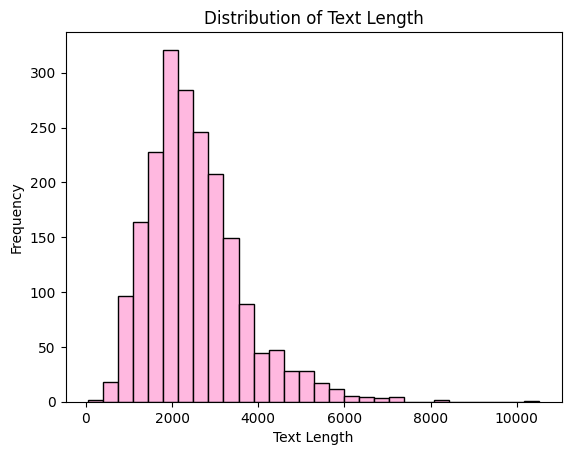

In [11]:
dataf['Text_Length'] = dataf['review'].apply(len)
print("\nDistribution of text length:")
print(dataf['Text_Length'].describe())
plt.hist(dataf['Text_Length'], bins=30, color='#FFB8E0', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length')
plt.show()

### 🔤 Text Normalization: Expand Abbreviations & Slang


In [12]:
normalization_map = {
    'u': 'you',
    'ur': 'your',
    'r': 'are',
    'b4': 'before',
    'gr8': 'great',
    'gud': 'good',
    'pls': 'please',
    'plz': 'please',
    'thx': 'thanks',
    'l8r': 'later',
    'msg': 'message',
    'btw': 'by the way',
    'idk': 'i do not know',
    'imo': 'in my opinion'
}
def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_map[word] if word in normalization_map else word for word in words]
    normalized_text = ' '.join(normalized_words)
    return normalized_text
columns_to_normalize = ['review']
for column in columns_to_normalize:
    dataf[column] = dataf[column].apply(normalize_text)

dataf.head()

,review,sentiment,Text_Length
0,john carpenter directed stylish gory vampire f...,1,1524
1,many students strive get schools harvard princ...,1,2293
2,ralph fiennes carving nice niche genre period ...,1,3361
3,since oliver stones natural born killers movie...,1,2844
4,simply amazing green mile developed three hour...,1,3232


### 🌿 Stemming & Lemmatization
Reducing words to their root form to unify variations (e.g., "running" → "run"), which helps improve text consistency for analysis.

In [13]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [14]:
df['review'] = df['review'].apply(
    lambda x: [stemmer.stem(lemmatizer.lemmatize(word)) for word in word_tokenize(str(x))] if pd.notnull(x) else []
)

# String Convertion For review Column

In [17]:
columns_to_convert = ['review']
for column in columns_to_convert:
    dataf[column] = dataf[column].astype(str)
dataf.head()

,review,sentiment,Text_Length
0,john carpenter directed stylish gory vampire f...,1,1524
1,many students strive get schools harvard princ...,1,2293
2,ralph fiennes carving nice niche genre period ...,1,3361
3,since oliver stones natural born killers movie...,1,2844
4,simply amazing green mile developed three hour...,1,3232


# Display Word Frequencies throw all reviews

In [18]:
all_joined_text = ' '.join(dataf['review'])
tokens = all_joined_text.split()
word_counts = Counter(tokens)
print("Most common words and their frequencies:")
for word, frequency in word_counts.most_common(20):
    print(f"{word}: {frequency}")

Most common words and their frequencies:
film: 8860
one: 5521
movie: 5440
like: 3553
even: 2555
good: 2320
time: 2283
story: 2118
films: 2102
would: 2042
much: 2024
also: 1965
characters: 1947
get: 1921
character: 1906
two: 1825
first: 1768
see: 1730
well: 1694
way: 1675


# Data Splitting

In [19]:
X_train, X_test, y_train, y_test = train_test_split(dataf['review'], dataf['sentiment'], test_size=0.2, random_state=0)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### 📊 TF-IDF (Term Frequency-Inverse Document Frequency)

A technique used to evaluate the importance of a word in a document relative to a collection of documents. It increases the weight of words that appear frequently in a specific document but not across all documents, helping capture key terms in text data.


In [20]:
X = dataf['review']
y = dataf['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 💻 Apply ML Models

# SVM Model

# Make Training

In [21]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
selector = SelectKBest(chi2, k=2000)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
models = {
    'LinearSVC': {
        'model': LinearSVC(random_state=42, max_iter=10000, class_weight='balanced'),
        'param_grid': {'C': [0.01, 0.1, 1, 10, 100]}
    },
    'SVC_Linear': {
        'model': SVC(kernel='linear', random_state=42, class_weight='balanced'),
        'param_grid': {'C': [0.01, 0.1, 1, 10, 100]}
    },
    'SVC_RBF': {
        'model': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
        'param_grid': {'C': [0.01, 0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.01, 0.1]}
    }
}
train_results = {}
best_model = None
best_cv_score = 0
best_model_name = ""

for model_name, config in models.items():
    print(f"\nTraining {model_name}...")
    grid_search = GridSearchCV(
        config['model'], config['param_grid'], cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_tfidf_selected, y_train)

    best_estimator = grid_search.best_estimator_
    y_train_pred = best_estimator.predict(X_train_tfidf_selected)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    train_results[model_name] = {
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'train_accuracy': train_accuracy,
        'best_estimator': best_estimator
    }

    if grid_search.best_score_ > best_cv_score:
        best_cv_score = grid_search.best_score_
        best_model = best_estimator
        best_model_name = model_name

print("\n=== Training Results ===")
for model_name, result in train_results.items():
    print(f"\n{model_name}:")
    print("Best Parameters:", result['best_params'])
    print("Best CV F1-Score:", result['cv_score'])
    print("Train Accuracy:", result['train_accuracy'])

print(f"\nBest Model (based on CV F1-Score): {best_model_name}")
print(f"Best CV F1-Score: {best_cv_score}")


Training LinearSVC...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Training SVC_Linear...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Training SVC_RBF...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== Training Results ===

LinearSVC:
Best Parameters: {'C': 1}
Best CV F1-Score: 0.9006186776084005
Train Accuracy: 0.986875

SVC_Linear:
Best Parameters: {'C': 1}
Best CV F1-Score: 0.8949732991901994
Train Accuracy: 0.95875

SVC_RBF:
Best Parameters: {'C': 10, 'gamma': 'scale'}
Best CV F1-Score: 0.8968524909746255
Train Accuracy: 1.0

Best Model (based on CV F1-Score): LinearSVC
Best CV F1-Score: 0.9006186776084005


In [22]:
from sklearn.metrics import accuracy_score, classification_report
X_test_tfidf_selected = selector.transform(X_test_tfidf)
test_results = {}
best_test_accuracy = 0
best_test_model_name = ""

for model_name, result in train_results.items():
    print(f"\nEvaluating {model_name} on test data...")
    best_estimator = result['best_estimator']
    y_pred = best_estimator.predict(X_test_tfidf_selected)
    test_accuracy = accuracy_score(y_test, y_pred)

    test_results[model_name] = {
        'test_accuracy': test_accuracy,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_test_model_name = model_name
print("\n=== Test Results ===")
for model_name, result in test_results.items():
    print(f"\n{model_name}:")
    print("Test Accuracy:", result['test_accuracy'])
    print("Classification Report:", result['classification_report'])

print(f"\nBest Model (based on Test Accuracy): {best_test_model_name}")
print(f"Best Test Accuracy: {best_test_accuracy}")


Evaluating LinearSVC on test data...

Evaluating SVC_Linear on test data...

Evaluating SVC_RBF on test data...

=== Test Results ===

LinearSVC:
Test Accuracy: 0.8725
Classification Report: {'0': {'precision': 0.8865979381443299, 'recall': 0.8557213930348259, 'f1-score': 0.8708860759493671, 'support': 201.0}, '1': {'precision': 0.8592233009708737, 'recall': 0.8894472361809045, 'f1-score': 0.8740740740740741, 'support': 199.0}, 'accuracy': 0.8725, 'macro avg': {'precision': 0.8729106195576017, 'recall': 0.8725843146078651, 'f1-score': 0.8724800750117205, 'support': 400.0}, 'weighted avg': {'precision': 0.8729790561505354, 'recall': 0.8725, 'f1-score': 0.8724721050164089, 'support': 400.0}}

SVC_Linear:
Test Accuracy: 0.8775
Classification Report: {'0': {'precision': 0.8725490196078431, 'recall': 0.8855721393034826, 'f1-score': 0.8790123456790123, 'support': 201.0}, '1': {'precision': 0.8826530612244898, 'recall': 0.8693467336683417, 'f1-score': 0.8759493670886076, 'support': 199.0}, '

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', KNeighborsClassifier())
])
knn_param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9],
    'clf__weights': ['uniform', 'distance'],
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__p': [1, 2]
}
print("\nTraining kNN Model...")
knn_grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
knn_grid_search.fit(X_train, y_train)
train_results = {
    'best_params': knn_grid_search.best_params_,
    'cv_score': knn_grid_search.best_score_,
    'best_estimator': knn_grid_search.best_estimator_
}
y_train_pred = knn_grid_search.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n=== kNN Training Results ===")
print("Best Parameters:", train_results['best_params'])
print("Best CV Accuracy:", train_results['cv_score'])
print("Training Accuracy:", train_accuracy)


Training kNN Model...
Fitting 5 folds for each of 64 candidates, totalling 320 fits

=== kNN Training Results ===
Best Parameters: {'clf__algorithm': 'auto', 'clf__n_neighbors': 7, 'clf__p': 2, 'clf__weights': 'distance'}
Best CV Accuracy: 0.6799999999999999
Training Accuracy: 1.0


In [24]:
from sklearn.metrics import accuracy_score, classification_report
print("\nEvaluating kNN Model on Test Data...")
best_estimator = train_results['best_estimator']
y_pred = best_estimator.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_results = {
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

print("\n=== kNN Test Results ===")
print("Test Accuracy:", test_results['test_accuracy'])
print("Classification Report:", test_results['classification_report'])


Evaluating kNN Model on Test Data...

=== kNN Test Results ===
Test Accuracy: 0.685
Classification Report: {'0': {'precision': 0.7094972067039106, 'recall': 0.6318407960199005, 'f1-score': 0.6684210526315789, 'support': 201.0}, '1': {'precision': 0.665158371040724, 'recall': 0.7386934673366834, 'f1-score': 0.7, 'support': 199.0}, 'accuracy': 0.685, 'macro avg': {'precision': 0.6873277888723173, 'recall': 0.6852671316782919, 'f1-score': 0.6842105263157894, 'support': 400.0}, 'weighted avg': {'precision': 0.6874386359614753, 'recall': 0.685, 'f1-score': 0.6841315789473683, 'support': 400.0}}


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
print("\nTraining Logistic Regression Model...")
logistic_reg_model = LogisticRegression(random_state=42)
logistic_reg_model.fit(X_train_tfidf, y_train)
y_train_pred = logistic_reg_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_results = {
    'train_accuracy': train_accuracy,
    'trained_model': logistic_reg_model
}
print("\n=== Logistic Regression Training Results ===")
print("Training Accuracy:", train_results['train_accuracy'])


Training Logistic Regression Model...

=== Logistic Regression Training Results ===
Training Accuracy: 0.964375


In [26]:
from sklearn.metrics import accuracy_score, classification_report
print("\nEvaluating Logistic Regression Model on Test Data...")
trained_model = train_results['trained_model']
y_pred = trained_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
test_results = {
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

print("\n=== Logistic Regression Test Results ===")
print("Test Accuracy:", test_results['test_accuracy'])
print("Classification Report:", test_results['classification_report'])


Evaluating Logistic Regression Model on Test Data...

=== Logistic Regression Test Results ===
Test Accuracy: 0.8575
Classification Report: {'0': {'precision': 0.86, 'recall': 0.8557213930348259, 'f1-score': 0.85785536159601, 'support': 201.0}, '1': {'precision': 0.855, 'recall': 0.8592964824120602, 'f1-score': 0.8571428571428571, 'support': 199.0}, 'accuracy': 0.8575, 'macro avg': {'precision': 0.8574999999999999, 'recall': 0.857508937723443, 'f1-score': 0.8574991093694335, 'support': 400.0}, 'weighted avg': {'precision': 0.8575125, 'recall': 0.8575, 'f1-score': 0.8575008906305663, 'support': 400.0}}


In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
print("\nTraining Naive Bayes Model...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_train_pred = nb_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)

train_results = {
    'train_accuracy': train_accuracy,
    'trained_model': nb_model
}
print("\n=== Naive Bayes Training Results ===")
print("Training Accuracy:", train_results['train_accuracy'])


Training Naive Bayes Model...

=== Naive Bayes Training Results ===
Training Accuracy: 0.930625


In [28]:
from sklearn.metrics import accuracy_score, classification_report
print("\nEvaluating Naive Bayes Model on Test Data...")
trained_model = train_results['trained_model']
y_pred = trained_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
test_results = {
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

print("\n=== Naive Bayes Test Results ===")
print("Test Accuracy:", test_results['test_accuracy'])
print("Classification Report:", test_results['classification_report'])


Evaluating Naive Bayes Model on Test Data...

=== Naive Bayes Test Results ===
Test Accuracy: 0.83
Classification Report: {'0': {'precision': 0.8093023255813954, 'recall': 0.8656716417910447, 'f1-score': 0.8365384615384616, 'support': 201.0}, '1': {'precision': 0.8540540540540541, 'recall': 0.7939698492462312, 'f1-score': 0.8229166666666666, 'support': 199.0}, 'accuracy': 0.83, 'macro avg': {'precision': 0.8316781898177248, 'recall': 0.8298207455186379, 'f1-score': 0.8297275641025641, 'support': 400.0}, 'weighted avg': {'precision': 0.8315663104965431, 'recall': 0.83, 'f1-score': 0.8297616185897436, 'support': 400.0}}


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
dt_model = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

print("\nTraining Decision Tree Model...")
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
dt_grid_search.fit(X_train_tfidf, y_train)

train_results = {
    'best_params': dt_grid_search.best_params_,
    'cv_score': dt_grid_search.best_score_,
    'best_estimator': dt_grid_search.best_estimator_
}
y_train_pred = dt_grid_search.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)

print("\n=== Decision Tree Training Results ===")
print("Best Parameters:", train_results['best_params'])
print("Best CV Accuracy:", train_results['cv_score'])
print("Training Accuracy:", train_accuracy)


Training Decision Tree Model...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

=== Decision Tree Training Results ===
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Accuracy: 0.67375
Training Accuracy: 0.7925


In [30]:
from sklearn.metrics import accuracy_score, classification_report
print("\nEvaluating Decision Tree Model on Test Data...")
best_estimator = train_results['best_estimator']
y_pred = best_estimator.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
test_results = {
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

print("\n=== Decision Tree Test Results ===")
print("Test Accuracy:", test_results['test_accuracy'])
print("Classification Report:", test_results['classification_report'])


Evaluating Decision Tree Model on Test Data...

=== Decision Tree Test Results ===
Test Accuracy: 0.68
Classification Report: {'0': {'precision': 0.7552447552447552, 'recall': 0.5373134328358209, 'f1-score': 0.627906976744186, 'support': 201.0}, '1': {'precision': 0.6381322957198443, 'recall': 0.8241206030150754, 'f1-score': 0.7192982456140351, 'support': 199.0}, 'accuracy': 0.68, 'macro avg': {'precision': 0.6966885254822998, 'recall': 0.6807170179254481, 'f1-score': 0.6736026111791106, 'support': 400.0}, 'weighted avg': {'precision': 0.696981306631112, 'recall': 0.68, 'f1-score': 0.6733741330069359, 'support': 400.0}}


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}
print("\nTraining Random Forest Model...")
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X_train_tfidf, y_train)
train_results = {
    'best_params': rf_grid_search.best_params_,
    'cv_score': rf_grid_search.best_score_,
    'best_estimator': rf_grid_search.best_estimator_
}
y_train_pred = rf_grid_search.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\n=== Random Forest Training Results ===")
print("Best Parameters:", train_results['best_params'])
print("Best CV Accuracy:", train_results['cv_score'])
print("Training Accuracy:", train_accuracy)


Training Random Forest Model...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

=== Random Forest Training Results ===
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.8231249999999999
Training Accuracy: 1.0


In [32]:
from sklearn.metrics import accuracy_score, classification_report
print("\nEvaluating Random Forest Model on Test Data...")
best_estimator = train_results['best_estimator']
y_pred = best_estimator.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_pred)
test_results = {
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}

print("\n=== Random Forest Test Results ===")
print("Test Accuracy:", test_results['test_accuracy'])
print("Classification Report:", test_results['classification_report'])


Evaluating Random Forest Model on Test Data...

=== Random Forest Test Results ===
Test Accuracy: 0.845
Classification Report: {'0': {'precision': 0.8202764976958525, 'recall': 0.8855721393034826, 'f1-score': 0.8516746411483254, 'support': 201.0}, '1': {'precision': 0.8743169398907104, 'recall': 0.8040201005025126, 'f1-score': 0.837696335078534, 'support': 199.0}, 'accuracy': 0.845, 'macro avg': {'precision': 0.8472967187932814, 'recall': 0.8447961199029976, 'f1-score': 0.8446854881134297, 'support': 400.0}, 'weighted avg': {'precision': 0.8471616176877943, 'recall': 0.845, 'f1-score': 0.8447204338786043, 'support': 400.0}}


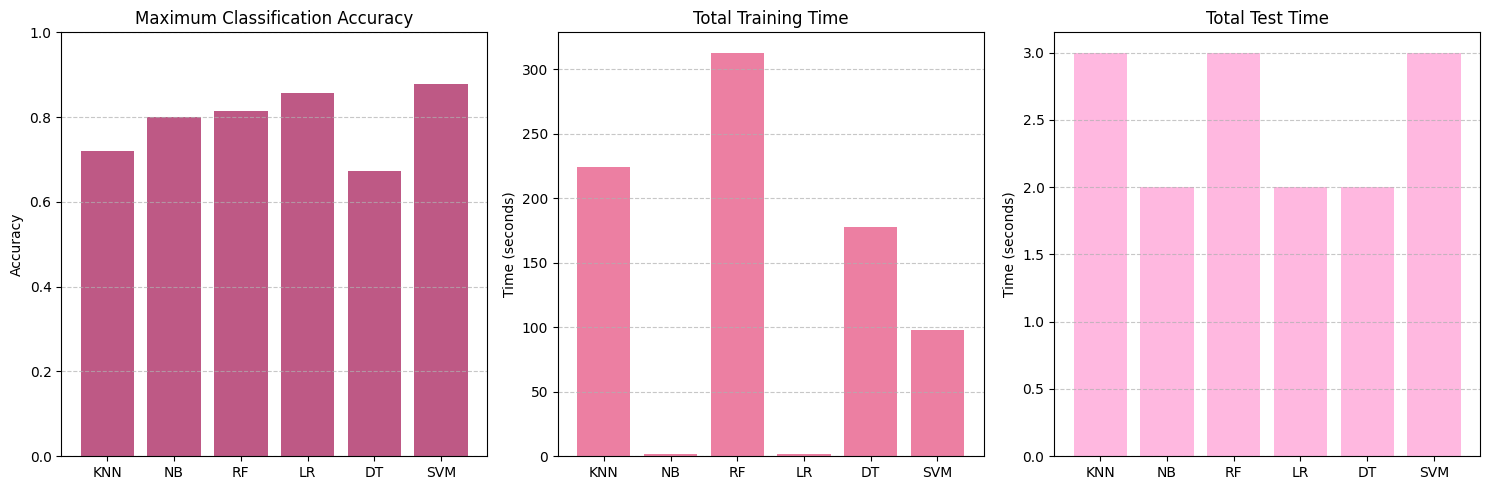

In [33]:
import matplotlib.pyplot as plt
import numpy as np

models = ['KNN', 'NB', 'RF' , 'LR' , 'DT' , 'SVM']
accuracy = [0.72, 0.80, 0.815 , 0.8575, 0.6725 , 0.8775]
training_time = [224, 2, 313 , 2 , 178 , 98]  # Training time in seconds
test_time = [3 , 2 , 3 , 2 , 2 , 3]  # Test time in seconds


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.bar(models, accuracy, color='#BE5985')
ax1.set_title('Maximum Classification Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.bar(models, training_time, color='#EC7FA2')
ax2.set_title('Total Training Time')
ax2.set_ylabel('Time (seconds)')
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)

ax3.bar(models, test_time, color='#FFB8E0')
ax3.set_title('Total Test Time')
ax3.set_ylabel('Time (seconds)')
ax3.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

# Conclusion The Best Model --> ML Model (SVM)
## SVM Model: with Kernel => Linear

### *   SVC_Linear
### *   Best Parameters: {'C': 1}
### *   Best CV F1-Score: 0.8949732991901994
### *   Train Accuracy: 0.95875
### *   Test Accuracy: 0.8775



## 🧠 Deep Learning Models

Before feeding text data into a deep learning model like a CNN, RNN, or GRU, we need to convert the raw text into a numerical format that the model can process. This involves several steps:

1. **Tokenization**:  
   We use a tokenizer to convert each review (sentence) into a sequence of integers, where each integer represents a word's index in the vocabulary. This step transforms free-form text into a structured format.

2. **Padding**:  
   Since neural networks require inputs of the same length, we pad all sequences to a fixed maximum length (`max_len`). This ensures uniform input shape regardless of the original sentence length.

3. **Vocabulary Limiting**:  
   We define a maximum number of words (`max_words`) to keep in the vocabulary. Words outside this limit are treated as out-of-vocabulary (OOV) tokens.


In [34]:
X= dataf['review']
y = dataf['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
max_words = 5000
max_len = 200
X_train = X_train.astype(str).tolist()
X_test = X_test.astype(str).tolist()
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
y_train_cnn = np.array(y_train)
y_test_cnn = np.array(y_test)

In [35]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    Conv1D(128, 5, activation='relu',kernel_regularizer=l2(0.001)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train_cnn, epochs=10, batch_size=32, validation_split=0.1)
train_loss, train_acc = model.evaluate(X_train_pad, y_train_cnn, verbose=0)
test_loss, test_acc = model.evaluate(X_test_pad, y_test_cnn, verbose=0)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test_cnn, y_pred))

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5218 - loss: 0.8143 - val_accuracy: 0.4938 - val_loss: 0.7749
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6109 - loss: 0.7553 - val_accuracy: 0.5063 - val_loss: 0.7427
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6259 - loss: 0.7220 - val_accuracy: 0.6438 - val_loss: 0.7214
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8481 - loss: 0.6700 - val_accuracy: 0.8313 - val_loss: 0.6587
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8822 - loss: 0.5235 - val_accuracy: 0.7937 - val_loss: 0.5167
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9628 - loss: 0.2582 - val_accuracy: 0.7812 - val_loss: 0.5244
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9916 - loss: 0.1507 - val_accuracy: 0.7688 - val_loss: 0.5526
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9992 - loss: 0.1142 - val_accuracy: 0.7875 - v

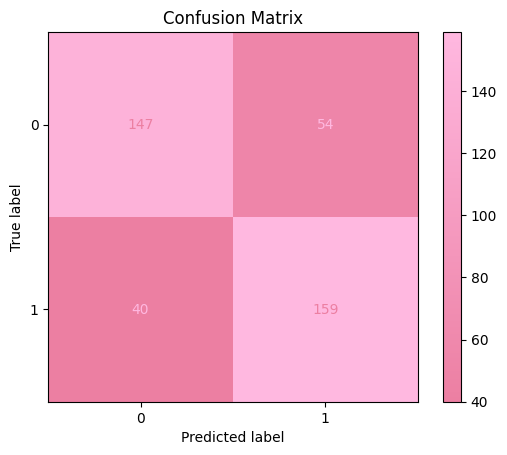

In [37]:
cm = confusion_matrix(y_test_cnn, y_pred)
colors = ['#EC7FA2', '#FFB8E0']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.title("Confusion Matrix")
plt.show()

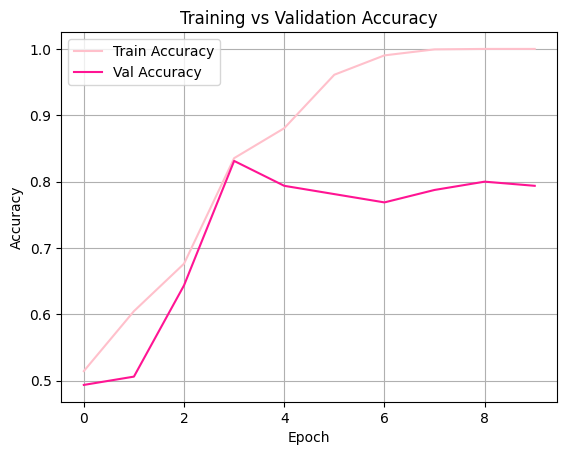

In [38]:
plt.plot(history.history['accuracy'], label='Train Accuracy',color='pink')
plt.plot(history.history['val_accuracy'], label='Val Accuracy',color='deeppink')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

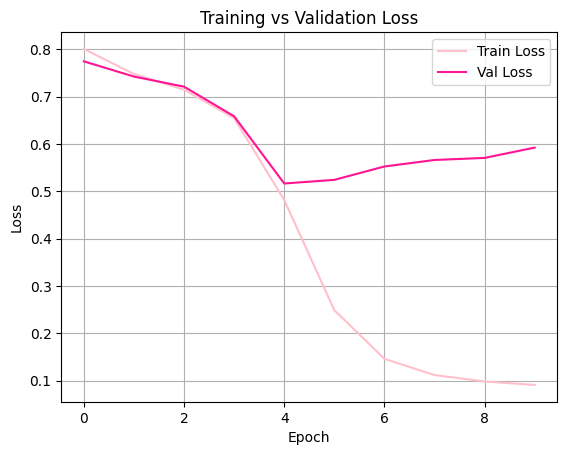

In [39]:
plt.plot(history.history['loss'], label='Train Loss',color='pink')
plt.plot(history.history['val_loss'], label='Val Loss',color='deeppink')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 🔁 Gated Recurrent Unit (GRU) for Text Classification

GRU is a type of recurrent neural network (RNN) that is effective at capturing sequential dependencies in text. Unlike CNNs, GRUs process input one step at a time, making them suitable for understanding the context and flow of words. This model includes:

- An Embedding layer for word representation.
- A GRU layer to capture sequential patterns.
- Dense layers for final classification.
- Dropout and regularization to prevent overfitting.

In [40]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(np.array(X_train_pad), np.array(y_train),
                    epochs=10, batch_size=32, validation_split=0.1)
train_loss, train_acc = model.evaluate(np.array(X_train_pad), np.array(y_train), verbose=0)
test_loss, test_acc = model.evaluate(np.array(X_test_pad), np.array(y_test), verbose=0)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test_cnn, y_pred))

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.5227 - loss: 0.6934 - val_accuracy: 0.5063 - val_loss: 0.6915
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.6546 - loss: 0.6730 - val_accuracy: 0.5938 - val_loss: 0.6544
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.8524 - loss: 0.4456 - val_accuracy: 0.7000 - val_loss: 0.7592
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.9419 - loss: 0.1643 - val_accuracy: 0.6812 - val_loss: 0.9329
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.9804 - loss: 0.0518 - val_accuracy: 0.6625 - val_loss: 1.2632
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.9861 - loss: 0.0348 - val_accuracy: 0.6562 - val_loss: 1.4623
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.9962 - loss: 0.0095 - val_accuracy: 0.6500 - val_loss: 1.5828
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9950 - loss: 0.0175 - val_accura

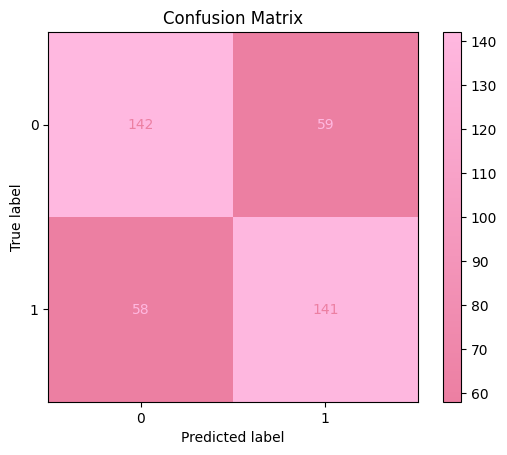

In [42]:
cm = confusion_matrix(y_test_cnn, y_pred)
colors = ['#EC7FA2', '#FFB8E0']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap)
plt.title("Confusion Matrix")
plt.show()

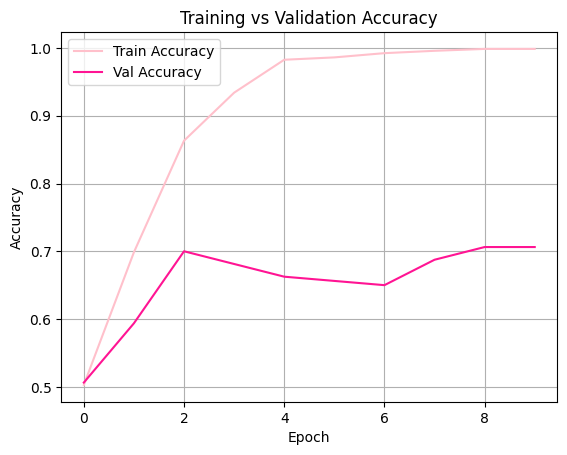

In [43]:
plt.plot(history.history['accuracy'], label='Train Accuracy',color='pink')
plt.plot(history.history['val_accuracy'], label='Val Accuracy',color='deeppink')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

simple RNN model

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.4991 - loss: 0.6985 - val_accuracy: 0.4563 - val_loss: 0.7056
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.5514 - loss: 0.6907 - val_accuracy: 0.5250 - val_loss: 0.6903
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5175 - loss: 0.7053 - val_accuracy: 0.5312 - val_loss: 0.6985
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.4921 - loss: 0.7067 - val_accuracy: 0.5188 - val_loss: 0.7066
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5321 - loss: 0.7007 - val_accuracy: 0.5125 - val_loss: 0.6972
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.5125 - loss: 0.7042 - val_accuracy: 0.4500 - val_loss: 0.7048
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5439 - loss: 0.6908 - val_accuracy: 0.5188 - val_loss: 0.6964
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.4978 - loss: 0.7189 - val_accuracy: 0.5750 - val_loss: 0.

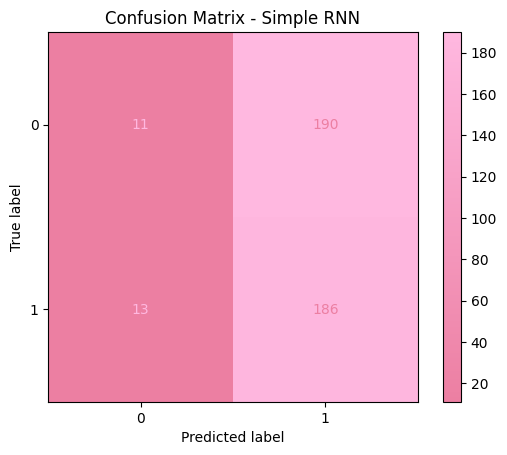

In [44]:
from tensorflow.keras.layers import SimpleRNN

# Build
rnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    SimpleRNN(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
rnn_history = rnn_model.fit(
    np.array(X_train_pad), np.array(y_train),
    epochs=10, batch_size=32, validation_split=0.1
)

# Evaluate
train_loss, train_acc = rnn_model.evaluate(np.array(X_train_pad), np.array(y_train), verbose=0)
test_loss, test_acc = rnn_model.evaluate(np.array(X_test_pad), np.array(y_test), verbose=0)
print(f"\nRNN Train Accuracy: {train_acc:.4f}")
print(f"RNN Test Accuracy: {test_acc:.4f}")

# Confusion matrix

y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
disp_rnn = ConfusionMatrixDisplay(confusion_matrix=cm_rnn)
disp_rnn.plot(cmap=cmap)
plt.title("Confusion Matrix - Simple RNN")
plt.show()

In [ ]:
#RNN plots
# Accuracy
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy',color='pink')
plt.plot(rnn_history.history['val_accuracy'], label='Val Accuracy',color='deeppink')
plt.title('Simple RNN: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(rnn_history.history['loss'], label='Train Loss',color='pink')
plt.plot(rnn_history.history['val_loss'], label='Val Loss',color='deeppink')
plt.title('Simple RNN: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


LSTM (long  short-term memory) model

In [ ]:
from tensorflow.keras.layers import LSTM

# Build
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
lstm_history = lstm_model.fit(
    np.array(X_train_pad), np.array(y_train),
    epochs=10, batch_size=32, validation_split=0.1
)

# Evaluate
train_loss, train_acc = lstm_model.evaluate(np.array(X_train_pad), np.array(y_train), verbose=0)
test_loss, test_acc = lstm_model.evaluate(np.array(X_test_pad), np.array(y_test), verbose=0)
print(f"\nLSTM Train Accuracy: {train_acc:.4f}")
print(f"LSTM Test Accuracy: {test_acc:.4f}")

# Confusion matrix

y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm)
disp_lstm.plot(cmap=cmap)
plt.title("Confusion Matrix - LSTM")
plt.show()

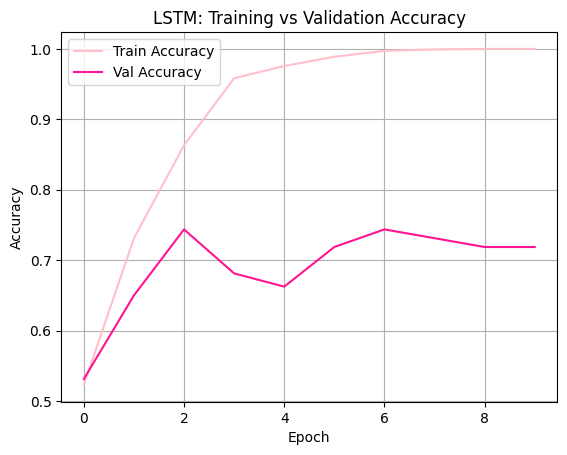

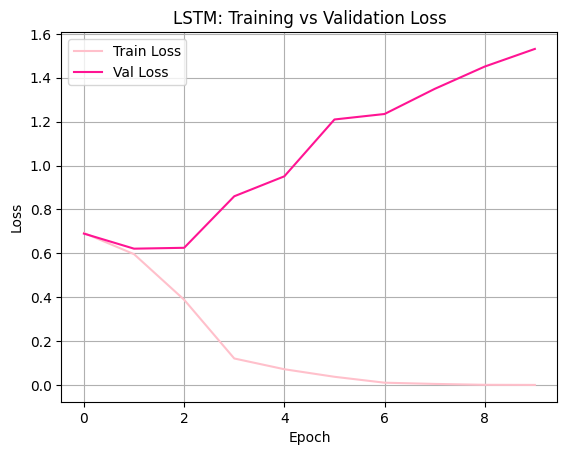

In [47]:
#plot

# Accuracy
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy',color='pink')
plt.plot(lstm_history.history['val_accuracy'], label='Val Accuracy',color='deeppink')
plt.title('LSTM: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(lstm_history.history['loss'], label='Train Loss',color='pink')
plt.plot(lstm_history.history['val_loss'], label='Val Loss',color='deeppink')
plt.title('LSTM: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 🧠 Conclusion

After training and evaluating multiple deep learning models, including CNN and GRU, and visualizing their performance through accuracy/loss graphs and confusion matrices, it became evident that the models exhibited signs of overfitting. Despite using regularization, dropout, and even augmentation, the training performance was much higher than the test performance—indicating that the models were likely too complex for the nature of the problem and dataset.

A key takeaway is the difference in **preprocessing needs** between traditional machine learning models and deep learning models:

- **Traditional models** (e.g., Logistic Regression, Random Forest) work well with techniques like TF-IDF or Bag-of-Words and do not require sequence padding or embeddings.
- **Deep learning models**, on the other hand, require tokenization, integer encoding, padding to uniform length, and often benefit from pretrained word embeddings like GloVe.

In this case, traditional models not only required simpler preprocessing but also outperformed deep models in terms of generalization, proving more suitable for this specific text classification task.
